## Authenticate to workspace

In [3]:
import os
import azureml.core
import azureml.contrib.dataset
from azureml.core import Dataset, Workspace, Experiment
from azureml.contrib.dataset import FileHandlingOption

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)
print("Azure ML Contrib Version", azureml.contrib.dataset.VERSION)

# load workspace
ws = Workspace.from_config()
print('Workspace name: ' + workspace.name, 
      'Azure region: ' + workspace.location, 
      'Subscription id: ' + workspace.subscription_id, 
      'Resource group: ' + workspace.resource_group, sep='\n')

Azure ML SDK Version:  1.10.0
Azure ML Contrib Version 1.10.0
Workspace name: mlserviceworkspace
Azure region: westus2
Subscription id: 601f4351-33bb-4d76-96ca-886940409b3d
Resource group: mlserviceworkspace


## Retrieve the labeled dataset

In [5]:
from azureml.contrib.dataset import FileHandlingOption
dataset = Dataset.get_by_name(ws, name='animalsclassifierml-2020-03-31 03:28:11')

In [6]:
animal_pd = dataset.to_pandas_dataframe(file_handling_option=FileHandlingOption.DOWNLOAD, target_path='./download_labeled/', overwrite_download=True)
animal_pd

,image_url,label,label_confidence
0,C:\Users\meranjit\mlserviceworkspace\animals\d...,dogs,1.0
1,C:\Users\meranjit\mlserviceworkspace\animals\d...,pandas,1.0
2,C:\Users\meranjit\mlserviceworkspace\animals\d...,pandas,1.0
3,C:\Users\meranjit\mlserviceworkspace\animals\d...,pandas,1.0
4,C:\Users\meranjit\mlserviceworkspace\animals\d...,dogs,1.0
...,...,...,...
1188,C:\Users\meranjit\mlserviceworkspace\animals\d...,pandas,1.0
1189,C:\Users\meranjit\mlserviceworkspace\animals\d...,dogs,1.0
1190,C:\Users\meranjit\mlserviceworkspace\animals\d...,dogs,1.0
1191,C:\Users\meranjit\mlserviceworkspace\animals\d...,dogs,1.0


In [7]:
animal_pd.label.unique()

array(['dogs', 'pandas'], dtype=object)

In [8]:
classLabels = ['dogs','pandas']

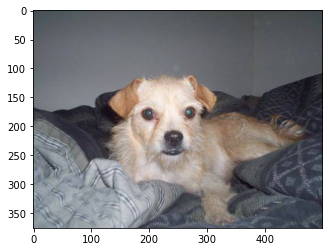

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# read images from downloaded path
img = mpimg.imread(animal_pd.loc[0,'image_url'])
imgplot = plt.imshow(img)

## Create a subset of data for testing

In [10]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Load the labeles and imagepaths in a dataframe
labels = list(animal_pd['label'])
imagePaths = list(animal_pd['image_url'])

data = []

# loop over the input images for preprocessing
for (i, imagePath) in enumerate(imagePaths):
    
    #preprocess the image
    image = cv2.imread(imagePath)
    image = cv2.resize(image,(32,32),interpolation=cv2.INTER_AREA)
    image = img_to_array(image)

    data.append(image)

(data, labels) = (np.array(data), np.array(labels))

#normalize images
data = data.astype("float") / 255.0

idxs = np.random.randint(0,len(imagePaths), size=(10,))
data = data[idxs]
labels = labels[idxs]

## Create compute

In [12]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "cpucluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D3_V2', 
                                                           max_nodes=4)

    # create the cluster
    compute_target = ComputeTarget.create(workspace, cluster_name, compute_config)

    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it uses the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

# use get_status() to get a detailed status for the current cluster. 
print(compute_target.get_status().serialize())

Found existing compute target
{'currentNodeCount': 2, 'targetNodeCount': 2, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 2, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2020-08-07T06:26:16.676000+00:00', 'errors': None, 'creationTime': '2019-11-27T00:07:55.199966+00:00', 'modifiedTime': '2020-08-07T06:25:41.121971+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 2, 'maxNodeCount': 2, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_D3_V2'}


## Define dependencies and training script

In [ ]:
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

conda_env = Environment('conda-env')
conda_env.python.conda_dependencies = CondaDependencies.create(pip_packages=['azureml-sdk','imutils','scikit-learn',
                                                                             'azureml-contrib-dataset',
                                                                             'tensorflow','numpy','opencv-python',
                                                                             'azureml-dataprep[pandas]','matplotlib'])

In [14]:
# create a directory
script_folder = './src'
os.makedirs(script_folder, exist_ok=True)

In [15]:
from azureml.train.estimator import Estimator

est = Estimator(source_directory=script_folder, 
                entry_script='train.py',
                inputs=[dataset.as_named_input('animal_labels')],
                compute_target=compute_target,
                environment_definition= conda_env)

In [16]:
from azureml.core import Experiment
# create an ML experiment
exp = Experiment(workspace=ws, name='animals-classifier')

In [17]:
run = exp.submit(est)

In [ ]:
run.wait_for_completion(show_output=True)

RunId: animals-classifier_1596892876_66a50241
Web View: https://ml.azure.com/experiments/animals-classifier/runs/animals-classifier_1596892876_66a50241?wsid=/subscriptions/601f4351-33bb-4d76-96ca-886940409b3d/resourcegroups/mlserviceworkspace/workspaces/mlserviceworkspace


## Register the model

In [ ]:
model_file_name = 'model.h5'

In [ ]:
# register the best model with the input dataset
model = run.register_model(model_name='animals_classifier', model_path=os.path.join('outputs', model_file_name),
                           datasets =[('animals',dataset)])

In [ ]:
model

## Scoring Script

In [ ]:
%%writefile score.py
import json
import numpy as np
import os
from tensorflow.keras.models import load_model
from azureml.core.model import Model

def init():
    global model    
    model_root = Model.get_model_path('animals_classifier')
    model = load_model(model_root)

def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_hat = np.argmax(model.predict(data), axis=1)
    return y_hat.tolist()

## Inference Config

In [ ]:
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

conda_env = Environment('conda-env-inf')
conda_env.python.conda_dependencies = CondaDependencies.create(pip_packages=['azureml-sdk','azureml-defaults',
                                                                             'tensorflow','numpy','keras'])

In [ ]:
from azureml.core.model import InferenceConfig
inference_config = InferenceConfig(entry_script="score.py",
                                   environment=conda_env)

## Create the AKS Compute

In [ ]:
from azureml.core.compute import AksCompute, ComputeTarget
from azureml.core.webservice import Webservice, AksWebservice
# Use the default configuration (can also provide parameters to customize)
prov_config = AksCompute.provisioning_configuration()
aks_config = AksWebservice.deploy_configuration()

aks_name = 'akscpucompute' 
# Create the cluster
aks_target = ComputeTarget.create(workspace = ws, 
                                  name = aks_name, 
                                  provisioning_configuration = prov_config)

In [ ]:
%%time
aks_target.wait_for_completion(show_output = True)
print(aks_target.provisioning_state)
print(aks_target.provisioning_errors)

In [ ]:
aks_target = ComputeTarget(workspace=ws, name=aks_name)
aks_target

## Deploy the model

In [ ]:
%%time
from azureml.core.model import Model
aks_service_name ='animals-classifier'

aks_service = Model.deploy(workspace=ws,
                           name=aks_service_name,
                           models=[model],
                           inference_config=inference_config,
                           deployment_config=aks_config,
                           deployment_target=aks_target,
                           overwrite=True)

aks_service.wait_for_deployment(show_output = True)
print(aks_service.state)

In [ ]:
aks_service.get_logs()

## Scoring URI and Keys

In [ ]:
aks_service = AksWebservice(ws, name = aks_service_name)
aks_service.scoring_uri

In [ ]:
aks_service.get_keys()[0]

## Test the webservice

In [ ]:
data[random_index].shape

In [ ]:
import requests

# send a random row from the test set to score
random_index = np.random.randint(0, len(idxs)-1)
input_data = "{\"data\": [" + str(data[random_index].tolist()) + "]}"

headers = {'Content-Type':'application/json', 'Authorization': 'Bearer ' + aks_service.get_keys()[0]}

resp = requests.post(aks_service.scoring_uri, input_data, headers=headers)
prediction = resp.json()[0]

print("POST to url", aks_service.scoring_uri)
print("label:", labels[random_index])
print("prediction:", classLabels[prediction])

In [ ]:
image = cv2.imread(imagePaths[random_index])
cv2.putText(image, "Label :{}".format(classLabels[prediction]), (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
cv2.imshow("Image", image)
cv2.waitKey(0)